<a href='rapids_motivation.png'>![test](rapids_motivation.png)</a>

# Scaling Data Science with RAPIDS on a Supervised Learning Problem
> In this notebook we measure CPU vs GPU performance to demonstrate how RAPIDS+GPUs can accelerate a sample data science workflow.

# Agenda

> Motivate RAPIDS [ show coverage of modern data science tools ]

> 0. Generate a synthetic dataset

> 1. Save and Load from Long Term Storage

> 2. Transform
    * 2.1 - Split Data [ train = 75%, test = 25% ]     
    * 2.2 - Scale Data [ standard scaler ]

> 3. Model Building 
    * 4.1 - Train CPU and GPU XGBoost classifier models 
    * 4.2 - Use trained models for inference
    * 4.3 - Compare accuracy
    * 4.4 - Visualize sample boosted trees & model predictions

> 4. Perf Analysis

> 5. Extensions 

# Library Imports 

In [1]:
# data arrays/frames
import cudf, numpy as np, pandas as pd
import cuml, sklearn

# algos, datasets
import xgboost; from xgboost import plot_tree
from sklearn import datasets; from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# measurement
import time
# plotting
import matplotlib.pylab as plt

In [3]:
import rapids_lib as rl
''' NOTE: anytime changes are made to rapids_lib.py you can either:
    1. refresh/reload via the code below, OR
    2. restart the kernel '''    
import importlib; importlib.reload(rl)

<module 'rapids_lib' from '/rapids/notebooks/rapids/rapids_lib.py'>

![choices](choices.png)

## <center> **Key Parameters and Default Settings** </center>
<center> <a href='chocices.png'><img width = 85% src=choices.png></a> </center>


### **Data Size** : total datasamples in dataset [ default = 5M ]
> recommended range for single-GPU: 1:25 million

In [4]:
NSAMPLES = 20000000
NCLASSES = 5

### **Data Format** : Data Format in Long-Term Storage [ 'CSV' or 'parquet'; default = parquet ]
*    [ option 1 ] CSV - textfile with comma delimited values, human readable
*    [ option 2 ] parquet - compressed storage, smaller on disk, faster to read

> recommended choice: **parquet** allows us to leverage compute to speed up data ingestion from the host


In [5]:
DATA_FORMAT = 'parquet'

### **Graphics** : Visualization Backend Mode [ '2D' or '3D'] 
*    [ option 1 ] 2D static - matplotlib.Axes3D
*    [ option 2 ] 3D interactive - ipyvolume [ <a href=galaxies_140ms.gif>demo animation</a>, Dockerfile ]

> recommended choice: **2D** for maximal interoperatbility with bare-bones RAPIDS installs, 3D is more fun :]



In [6]:
GRAPHICS_MODE = '3D'

### **Confirm Choices**

In [7]:
rl.accept_choices ( NSAMPLES, DATA_FORMAT, GRAPHICS_MODE )

Below are your current choices for the key parameters in the notebook, return to the cell above to revise them. 

                Number of Total Samples:  20000000
         Data Format [ CSV or parquet ]:  parquet
              GraphicsMode [ 2D or 3D ]:  3D


# Section 0 : Galaxy Generation
In order to do data science we need data, and lots of it. Lets use our fast computers to conjure up a dataset.

Luckily, we have a pre-built galaxy generator -- in our demo a galaxy is a set of blob planets randomly shifted around a common origin.

Let's look at the function `rl.generate_galaxy_dataset` that does this for us.

> Note: can load the code of this function in a local cell with the [jupyter magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-load) command **`%load -s generate_galaxy_dataset rapids_lib.py`**

In [8]:
?rl.generate_galaxy_dataset

Signature:
rl.generate_galaxy_dataset(
    nSamples=1000000,
    nGalaxies=5,
    nPlanets=5,
    nLabels=5,
    shuffleFlag=True,
    rSeed=None,
)
Docstring:
build random galaxy dataset on the GPU

galaxy = set of 3D random sized blobs, randomly offset from a common center

--- inputs --- 
    nSamples : total number of samples in the entire dataset [in all galaxies]
    nGalaxies : number of galaxies [ see definition above ]
    nClusters : number of blobs within a galaxy
    shuffleFlag : whether the blob samples should be randomly permuted
    rSeed : random seed for repeatability

--- returns --- 
    X : cuda DataFrame 3D points
    y : cuda DataFrame label
    t : elapsed time  
File:      /rapids/notebooks/rapids/rapids_lib.py
Type:      function


## Generating Examples
Lets take a look at a few examples of what this function can do [ using a small number of samples ].

### **Ex. 1** : Two Planets in a Galaxy

In [9]:
data, labels, _ = rl.generate_galaxy_dataset (nSamples = 10000, nGalaxies = 1, nPlanets = 2, rSeed = 2)
rl.visualize_data( data, labels)

generating shuffled samples n = 10000


plotting  10000 out of 10000  [ stride =  1 ]


### **Ex. 2** : Five Planets in a Galaxy

In [10]:
data, labels, _ = rl.generate_galaxy_dataset (nSamples = 10000, nGalaxies = 1, nPlanets = 5, rSeed = 2)
rl.visualize_data( data, labels)

generating shuffled samples n = 10000


plotting  10000 out of 10000  [ stride =  1 ]


### **Ex. 3** : Four Galaxies with Two Planets Each

In [11]:
data, labels, _ = rl.generate_galaxy_dataset (nSamples = 10000, nGalaxies = 4, nPlanets = 2, rSeed = 4)
rl.visualize_data(data,labels)

generating shuffled samples n = 10000


plotting  10000 out of 10000  [ stride =  1 ]


### **Ex 4** : Five Galaxies with Five Planets Each

In [12]:
data, labels, _ = rl.generate_galaxy_dataset (nSamples = 10000, nGalaxies = 5, nPlanets = 5, rSeed = 2)
rl.visualize_data( data, labels)

generating shuffled samples n = 10000


plotting  10000 out of 10000  [ stride =  1 ]


# Section 1. Build your Dataset

Next we'll build a galaxy dataset of size `NSAMPLES` similar in style to Ex.4 above. Feel free to modify any of the parameters to make a galaxy dataset of your hoice.

Before we begin lets also create a new experiment logbook for keeping track of how longs things take to compute.

In [13]:
expLog = {}

In [14]:
data, labels, t_gen = rl.generate_galaxy_dataset (nSamples = NSAMPLES, nGalaxies = 5, nPlanets = 5, nLabels = NCLASSES, rSeed = 1)

expLog = rl.update_log( expLog, [ ['generate_galaxy', t_gen] ] );

rl.visualize_data( data, labels)

generating shuffled samples n = 20000000
 + adding log entry [ generate_galaxy          :   0.07850 s ]


plotting  50000 out of 50000  [ stride =  400 ]


# Section 2. Extract/Load
We'll save the data to long term storage, then extract/ingest+decompress the data.

In [15]:
def query_latest_parquet_filename( destinationDirectory ):
    outputFilenames = !cd $destinationDirectory && ls -t
    latestFilename = destinationDirectory + '/' + outputFilenames[0]
    return latestFilename

def query_size_on_disk ( filename ):
    duOutput = !du -hs $filename
    fileSize = duOutput[0].split('\t')[0]
    return fileSize

def write_data_to_lts ( data, labels, mode = 'parquet', destinationDirectory = 'lts_data', fileTag = 'train', shardID = 0  ):        
    
    startTime = time.time()
    print('saving as', mode)
    if mode == 'parquet': 
        data.to_parquet( path = destinationDirectory, compression = 'snappy')
        filenameX = query_latest_parquet_filename(destinationDirectory)
        
        labels.to_parquet( path = destinationDirectory, compression = 'snappy')
        filenameY = query_latest_parquet_filename(destinationDirectory)
        
    elif mode == 'csv':
        filenameX = 'data_' + fileTag + '.csv'
        filenameY = 'labels_' + fileTag + '.csv'
        labels.to_csv( path = filenameX )
        data.to_csv( path = filenameY )
    
    elapsedTime = time.time() - startTime
        
    print( '   wrote {} DATA into {} '.format( query_size_on_disk(filenameX), filenameX) )
    print( '   wrote {} LABELS into {}'.format( query_size_on_disk(filenameY), filenameY ) )        
    
    return filenameX, filenameY, elapsedTime

def read_data_from_lts ( filenameData, filenameLabels, mode = 'parquet', device='GPU' ):    
    
    startTime = time.time()
    print('GPU/cudf reading from', mode)
    
    if mode == 'parquet':        
        if device == 'GPU': data_reader_function = cudf.read_parquet
        else: data_reader_function = pd.read_parquet
    elif mode == 'csv':
        if device == 'GPU': data_reader_function = cudf.read_csv
        else: data_reader_function = pd.read_csv

    data = data_reader_function( filenameData )
    labels = data_reader_function( filenameLabels )
    
    return data, labels, time.time() - startTime

In [16]:
# write to disk & load from disk
filenameX, filenameY, t_wLTS = write_data_to_lts ( data, labels, mode = DATA_FORMAT)

dataLTS, labelsLTS, t_rLTS = read_data_from_lts ( filenameX, filenameY, mode = DATA_FORMAT, device = 'GPU')
dataLTS_pDF, labelsLTS_pDF, t_rLTS_CPU = read_data_from_lts ( filenameX, filenameY, mode = DATA_FORMAT, device = 'CPU')

expLog = rl.update_log( expLog, [['write_data_to_lts_' + DATA_FORMAT, t_wLTS], 
                                 ['read_data_from_lts_' + DATA_FORMAT, t_rLTS],
                                 ['CPU_read_data_from_lts_' + DATA_FORMAT, t_rLTS_CPU]] );    

saving as parquet
   wrote 536M DATA into lts_data/400ead3fd93d43ea96e36bac50c10df5.parquet 
   wrote 84M LABELS into lts_data/9309739d58ab4427b995139b2ba39ebb.parquet
GPU/cudf reading from parquet
GPU/cudf reading from parquet
 + adding log entry [ write_data_to_lts_parquet:   6.53602 s ]
 + adding log entry [ read_data_from_lts_parquet:   0.91242 s ]
 + adding log entry [ CPU_read_data_from_lts_parquet:   1.25150 s ]


In [17]:
assert ( data == dataLTS and labels == labelsLTS) # confirm equality of data we generated and its copy read from LTS

In [18]:
# drop the original dataframes and retain the copy read from LTS, to minimize redundancy
del( data, labels); data = dataLTS; labels = labelsLTS; import gc; gc.collect();

# Section 3. Split and Normalize

# 3.1 Split data set into train and test

In [19]:
def split_train_test ( dataDF, labelsDF, trainRatio = .75 ):
    print('splitting data into training and test set')
    sT = time.time()
    
    splitIndex = int( dataDF.shape[0] * trainRatio )
    assert ( splitIndex > 1 and splitIndex < dataDF.shape[0] )
    assert ( dataDF.shape[0] == labelsDF.shape[0] )
    
    trainDF = dataDF.iloc[0:splitIndex]
    testDF = dataDF.iloc[splitIndex:]
    trainLabelsDF = labelsDF.iloc[0:splitIndex]
    testLablesDF = labelsDF.iloc[splitIndex:]
    
    return trainDF, trainLabelsDF, testDF, testLablesDF, time.time() - sT

## 3.2 Rescale/Normalize

In [20]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

### CPU split & scale

In [21]:
# split
trainData_pDF, trainLabels_pDF, testData_pDF, testLabels_pDF, t_split_CPU = split_train_test (data.to_pandas(), labels.to_pandas())
# apply standard scaling
trainMeans_CPU, trainSTDevs_CPU, t_scaleTrain_CPU = scale_dataframe_inplace ( trainData_pDF )
_,_, t_scaleTest_CPU = scale_dataframe_inplace ( testData_pDF, trainMeans_CPU, trainSTDevs_CPU )    

expLog = rl.update_log( expLog, [['CPU_split_train_test', t_split_CPU],
                                 ['CPU_scale_train_data', t_scaleTrain_CPU], 
                                 ['CPU_scale_test_data', t_scaleTest_CPU]] )

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ CPU_split_train_test     :   0.56925 s ]
 + adding log entry [ CPU_scale_train_data     :   1.76040 s ]
 + adding log entry [ CPU_scale_test_data      :   0.27358 s ]


### GPU split & scale

In [22]:
# split
trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = split_train_test (data, labels)
# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
_,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    

expLog = rl.update_log( expLog, [['split_train_test', t_split],
                                 ['scale_train_data', t_scaleTrain],
                                 ['scale_test_data', t_scaleTest]] ); 

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ split_train_test         :   0.00572 s ]
 + adding log entry [ scale_train_data         :   0.01020 s ]
 + adding log entry [ scale_test_data          :   0.00838 s ]


-----
# Section 4. - Model Building with XGBoost
-----
XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target). For a deeper dive into how XGBoost works check out the following dev blog: <br>
> https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/

<img src='xgboost.png' width =90%>
<center> img src: https://explained.ai/gradient-boosting/L2-loss.html </center>

## 4.1 - Model Training

In [23]:
def train_model (trainData_cDF, testData_cDF, paramsGPU = {}):
    
    print('training xgboost model on GPU');  
    startTime = time.time()    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, params = paramsGPU, num_boost_round = paramsGPU['num_boost_rounds'] )    
    return trainedModelGPU, time.time() - startTime

def train_model_CPU (trainData_cDF, testData_cDF, paramsCPU = {}):
    
    print('training xgboost model on {} CPU cores'.format(nCores) )    
    trainData_pDF = trainData_cDF.to_pandas()
    trainLabels_pDF = trainLabels_cDF.to_pandas()    
    
    startTime = time.time()
    xgBoostModelCPU = xgboost.XGBClassifier(max_depth = paramsCPU['max_depth'], 
                                            n_estimators = paramsCPU['n_estimators'],
                                            tree_method = paramsCPU['tree_method'],
                                            objective = paramsCPU['objective'],
                                            num_class = paramsCPU['num_class'],
                                            n_jobs = paramsCPU['n_jobs'])
    
    xgBoostModelCPU.fit( trainData_pDF, trainLabels_pDF )
    
    return xgBoostModelCPU, time.time() - startTime

In [24]:
nCores = !nproc --all
nCores = int(nCores[0])

paramsCPU = {
    'max_depth': 6,
    'n_estimators': 20,
    'objective': 'multi:softmax',
    'num_class': NCLASSES,
    'tree_method': 'hist',
    'n_jobs': nCores
}

paramsGPU = {
    'max_depth': 6,
    'num_boost_rounds': 10,    
    'objective': 'multi:softmax',
    'num_class': NCLASSES,
    'tree_method': 'gpu_hist',    
    'n_gpus': 1, 
    'random_state': 0
}

## 4.2 - Model Inference
i.e. using trained model to predict/infer classes of test data

In [25]:
def test_model ( trainedModelGPU, testData_cDF, testLabels_cDF ):    
    startTime = time.time()   
    testDMatrix = xgboost.DMatrix( testData_cDF.to_pandas(), label=testLabels_cDF.to_pandas())
    
    predictionsGPU = trainedModelGPU.predict(testDMatrix)    
    return predictionsGPU, time.time() - startTime

def test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on CPU')
    testData_pDF = testData_cDF.to_pandas()
    
    startTime = time.time()    
    predictionsCPU = trainedModelCPU.predict(testData_pDF)
    return predictionsCPU, time.time() - startTime

### Run CPU Model Training and Inference

In [26]:
# model training
trainedModelCPU, t_trainCPU = train_model_CPU ( trainData_cDF, trainLabels_cDF, paramsCPU )

training xgboost model on 40 CPU cores


In [27]:
# model inference
print('testing xgboost model')
predictionsCPU, t_inferCPU = test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF)

testing xgboost model
testing xgboost model on CPU


In [28]:
expLog = rl.update_log( expLog, [['CPU_model_training', t_trainCPU], ['CPU_model_inference', t_inferCPU]] ); 

 + adding log entry [ CPU_model_training       :  77.40300 s ]
 + adding log entry [ CPU_model_inference      :   1.67914 s ]


### Run GPU Model Training and Inference

In [29]:
# model training
trainedModelGPU, t_train = train_model ( trainData_cDF, trainLabels_cDF, paramsGPU )

training xgboost model on GPU


In [30]:
# model inference
predictionsGPU, t_infer = test_model ( trainedModelGPU, testData_cDF, testLabels_cDF)

In [31]:
expLog = rl.update_log( expLog, [['model_training', t_train], ['model_inference', t_infer]] ); 

 + adding log entry [ model_training           :   8.34403 s ]
 + adding log entry [ model_inference          :   1.05383 s ]


## 4.3 - Accuracy

In [32]:
testLabels_pDF = testLabels_cDF.to_pandas()
accuracyGPU = accuracy_score(testLabels_pDF, predictionsGPU)
accuracyCPU = accuracy_score(testLabels_pDF, predictionsCPU)
print( accuracyGPU )
print( accuracyCPU )

0.9953092
0.9911098


In [33]:
cMat = confusion_matrix(testLabels_pDF, predictionsGPU)

In [34]:
print(cMat)

[[ 916277     246     999     387     381]
 [      5  976348      28       3       0]
 [   1264      78  977787   10905     882]
 [     76     116    5991 1028998    1961]
 [     15       0      98      19 1077136]]


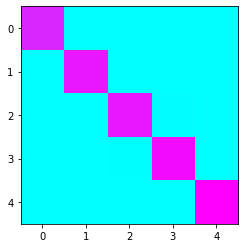

In [35]:
plt.imshow(cMat, cmap ='cool')

CPU times: user 221 ms, sys: 149 ms, total: 370 ms
Wall time: 942 ms


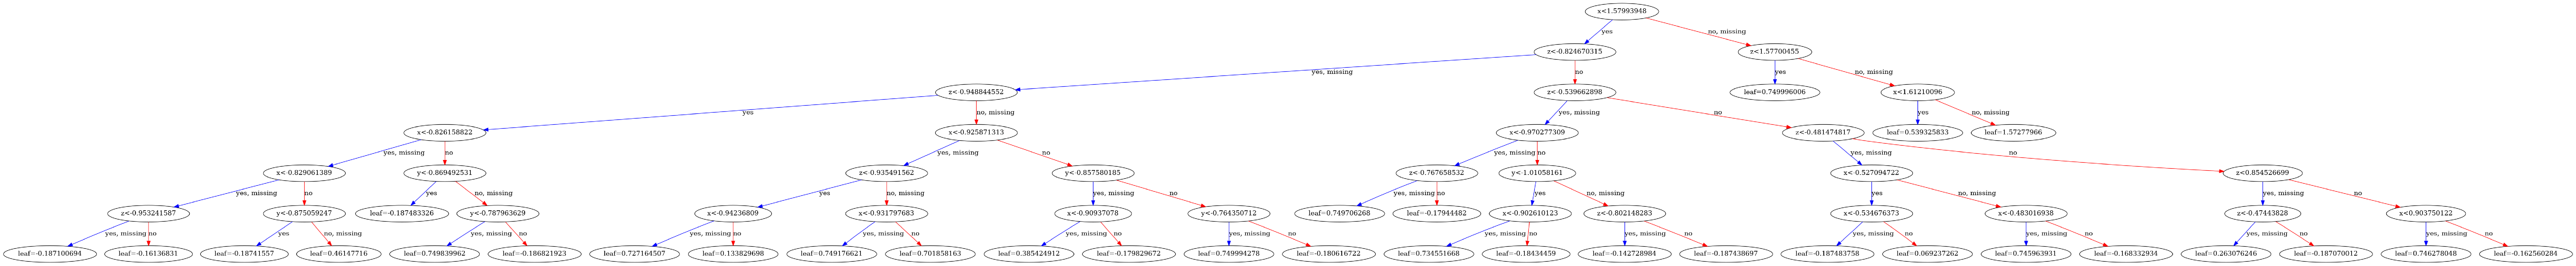

In [36]:
%%time
fig = plt.figure(figsize=(200,100))
plot_tree(trainedModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

## 4.4 - Visualize Mistakes [ CPU vs GPU ]

In [37]:
%%time
rl.visualize_data(trainData_cDF, trainLabels_cDF, maxSamplesToPlot=100000)

plotting  100000 out of 100000  [ stride =  150 ]
CPU times: user 1.77 s, sys: 60.2 ms, total: 1.83 s
Wall time: 1.82 s


In [38]:
rl.visualize_data( testData_cDF, predictionsGPU )

plotting  50000 out of 50000  [ stride =  100 ]


# Section 5. - Analyze Performance

In [39]:
expLog

{'generate_galaxy': 0.07849812507629395,
 'write_data_to_lts_parquet': 6.536022901535034,
 'read_data_from_lts_parquet': 0.9124197959899902,
 'CPU_read_data_from_lts_parquet': 1.2515037059783936,
 'CPU_split_train_test': 0.5692539215087891,
 'CPU_scale_train_data': 1.7603991031646729,
 'CPU_scale_test_data': 0.27358388900756836,
 'split_train_test': 0.005715608596801758,
 'scale_train_data': 0.010202884674072266,
 'scale_test_data': 0.008380889892578125,
 'CPU_model_training': 77.4029951095581,
 'CPU_model_inference': 1.6791439056396484,
 'model_training': 8.344034910202026,
 'model_inference': 1.0538337230682373}

In [68]:
''' ----------------------------------------------------------------------
 GEN
------------------------------------------------------------------------'''

generateSpeedGPU = np.mean( rl.query_log(expLog, 'generate_galaxy') )
generateSpeedCPU = 0 

''' ----------------------------------------------------------------------
 ETL
------------------------------------------------------------------------'''

readSpeedCPU = np.mean ( rl.query_log(expLog, 'CPU_read_data_from_lts_parquet') )
readSpeedGPU = np.mean ( rl.query_log(expLog, 'read_data_from_lts_parquet') )

splitSpeedCPU = np.mean( rl.query_log(expLog, 'CPU_split_train_test') )
scaleTrainSpeedCPU = np.mean( rl.query_log(expLog, 'CPU_scale_train_data') )
scaleTestSpeedCPU = np.mean( rl.query_log(expLog, 'CPU_scale_test_data') )

splitSpeedGPU = np.mean( rl.query_log(expLog, 'split_train_test') )
scaleTrainSpeedGPU = np.mean( rl.query_log(expLog, 'scale_train_data') )
scaleTestSpeedGPU = np.mean( rl.query_log(expLog, 'scale_test_data') )

transformSpeedCPU = splitSpeedCPU + scaleTrainSpeedCPU + scaleTestSpeedCPU
transformSpeedGPU = splitSpeedGPU + scaleTrainSpeedGPU + scaleTestSpeedGPU

''' ----------------------------------------------------------------------
 Model Training and Inference
------------------------------------------------------------------------'''

trainSpeedCPU = np.mean( rl.query_log(expLog, 'CPU_model_training') )
inferSpeedCPU = np.mean( rl.query_log(expLog, 'CPU_model_inference') )

trainSpeedGPU = np.mean( rl.query_log(expLog, 'model_training') )
inferSpeedGPU = np.mean( rl.query_log(expLog, 'model_inference') )
                           
accuracyCPU = accuracyCPU
accuracyGPU = accuracyGPU                        

expTimesDF =  pd.DataFrame({'experiment_id': ['CPU', 'GPU' ],
                            'data gen': [0, generateSpeedGPU],
                            'load': [readSpeedCPU, readSpeedGPU],
                            'transform': [ transformSpeedCPU, transformSpeedGPU ],
                            'train': [ trainSpeedCPU, trainSpeedGPU ],
                            'inference': [inferSpeedCPU, inferSpeedGPU ],
                            'accuracy': [ accuracyCPU, accuracyGPU ]},
                            columns=['experiment_id', 'data gen', 'load', 'transform', 'train', 'inference', 'accuracy'])

In [103]:
# compute speedups

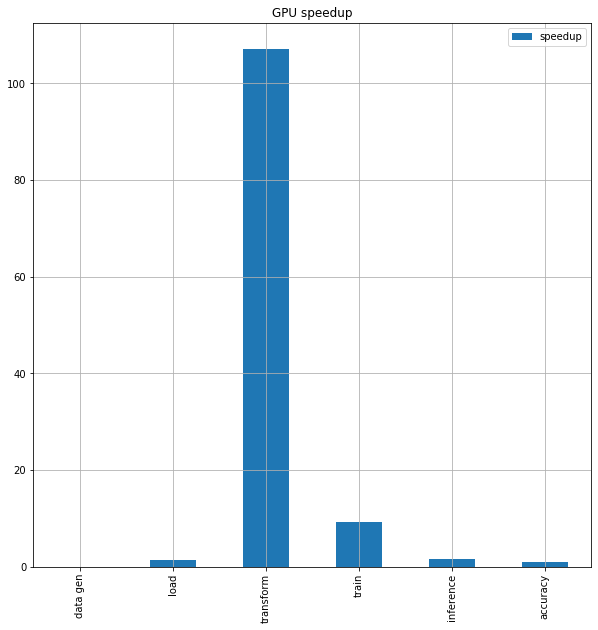

In [99]:
ax = pd.DataFrame(np.array(ratios), index=list(expTimesDF.columns)[1:], columns=['speedup'] ).plot.bar(figsize=(10,10), grid=True)
ax.set_title('GPU speedup');

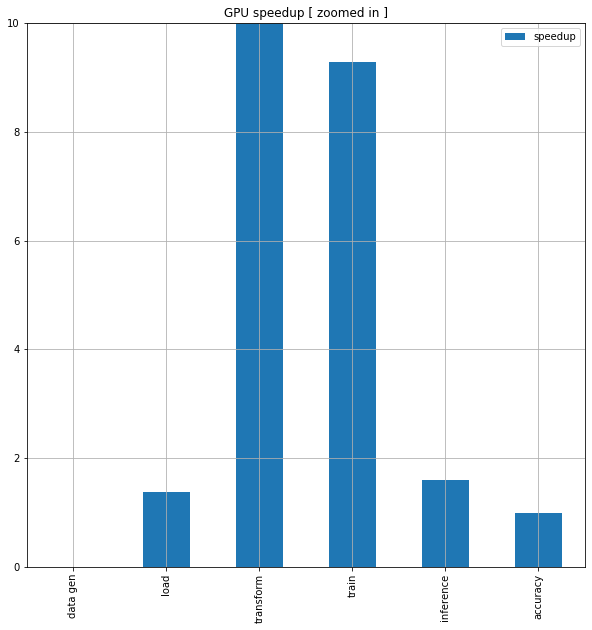

In [100]:
ax = pd.DataFrame(np.array(ratios), index=list(expTimesDF.columns)[1:], columns=['speedup'] ).plot.bar(figsize=(10,10), grid=True, ylim=(0,10))
ax.set_title('GPU speedup [ zoomed in ]');

In [101]:
expTimesDF

,experiment_id,data gen,load,transform,train,inference,accuracy
0,CPU,0.000000,1.251504,2.603237,77.402995,1.679144,0.991110
1,GPU,0.078498,0.912420,0.024299,8.344035,1.053834,0.995309


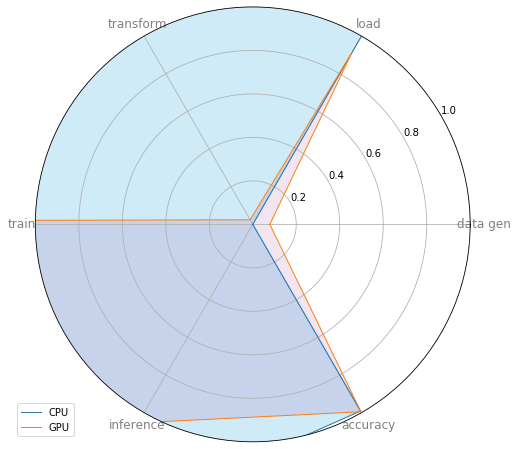

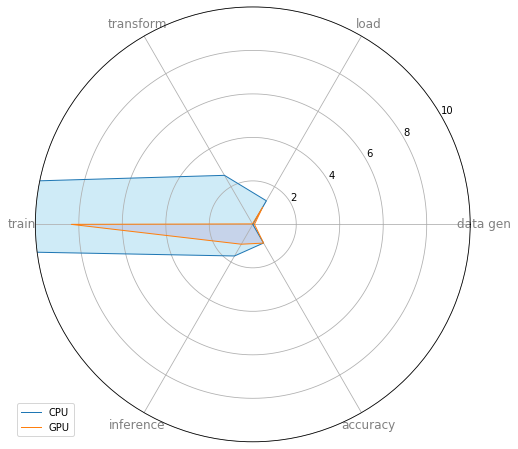

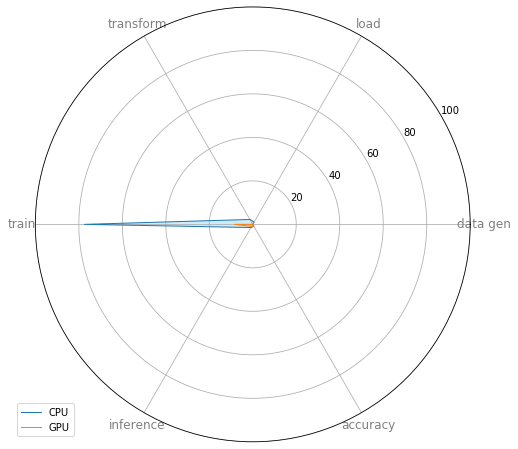

In [102]:
rl.viz_perf(expTimesDF, 1)
rl.viz_perf(expTimesDF, 10)
rl.viz_perf(expTimesDF, 100)

# Takeaways

RAPIDS + GPUs accelerate data science.

# Experiment Harness

In [ ]:
'''
%%time
#v1 - blocking 
expLog = {}

cupy.random.seed(1); # cupy.random.seed(12); 

for i in range(5):
    sT = time.time()
    
    # gpu based gen
    data, labels, t_gen = generate_shuffled_data ( nSamples = 1000000, nGalaxies = 5, nClusters = 5, shuffleFlag = True, shardID = 0 )
    data_cDF, labels_cDF, t_conv = convert_to_cuDFs ( data, labels)        
    expLog = update_log( expLog, [ ['generate_data_shard', t_gen] ] );
    
    df_info(data_cDF, 'data'); df_info(labels_cDF, 'labels')
    
    # write to disk & load from disk [ optional ]
    filenameX_CSV, filenameY_CSV, t_wLTS_csv = write_data_to_lts ( data_cDF, labels_cDF, mode = 'csv')
    filenameX, filenameY, t_wLTS_parquet = write_data_to_lts ( data_cDF, labels_cDF, mode = 'parquet')
    expLog = update_log( expLog, [['write_data_to_lts_CSV', t_wLTS_csv], ['write_data_to_lts_PARQUET', t_wLTS_parquet]] );    
    
    # split
    trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = split_train_test (data_cDF, labels_cDF)
    # apply standard scaling
    trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
    _,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    
    expLog = update_log( expLog, [['scale_train_data', t_scaleTrain], ['scale_test_data', t_scaleTest], ['split_train_test', t_split]] );    
    
    # -----
    # 
    # -----
    # model training
    trainedModelGPU, t_train = train_model ( trainData_cDF, trainLabels_cDF )
    
    # model inference
    predictionsGPU, t_infer = test_model ( trainedModelGPU, testData_cDF, testLabels_cDF)    
        
    expLog = update_log( expLog, [['model_training', t_train], ['model_inference', t_infer]] );    
    print( 'end to end time: ', time.time()-sT )
'''